In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# Matrix of step functions

amplitude = 5

X = torch.zeros(128, 129)
r = torch.randperm(128)
X[:, r] = amplitude * torch.tril(torch.ones(128, 128))

X_test = torch.zeros(128, 129)
X_test[:,:-1] = amplitude * torch.tril(torch.ones(128, 128))

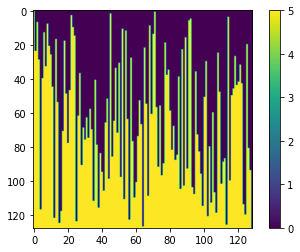

In [3]:
%matplotlib inline
plt.imshow(X)
plt.colorbar()

In [4]:
class AutoEncoder():

  def __init__(self, n_in, n_h1, n_h2, n_out):
    
    # Weight Initialization 
    
    # Layer 1
    self.W1 = -torch.randn(n_h1, n_in, dtype= torch.float)*0.001
    self.W1.requires_grad = True

    self.b1 = torch.randn(n_h1, 1, dtype = torch.float)*0.001
    self.b1.requires_grad = True

    # Layer 2
    self.W2 = -torch.randn(n_h2, n_h1, dtype= torch.float)*0.001
    self.W2.requires_grad = True
    
    self.b2 = torch.randn(n_h2,1, dtype= torch.float)*0.001
    self.b2.requires_grad = True

    # Layer 3
    self.W3 = torch.rand(n_out, n_h2, dtype= torch.float)*0.0001 #uniform to prevent dead neurons
    self.W3.requires_grad = True

    self.SW3 = 0
    self.SW2 = 0
    self.Sb2 = 0
    self.SW1 = 0
    self.Sb1 = 0
    
    self.i = 0

  def forward(self, X):
    
      u1 = self.W1 @ X + self.b1 
      self.z1 = u1

      u2 = self.W2 @ self.z1 + self.b2 
      self.z2 = torch.clamp(u2, 0)

      u3 = self.W3 @ self.z2 
      self.y = torch.clamp(u3, 0) 

      return self.y

  def optim_step(self, alpha = 1e-3, gamma = 0.99):
    with torch.no_grad():

      self.SW3 = gamma * self.SW3 + (1-gamma) * self.W3.grad **2
      self.W3 -= alpha * self.W3.grad / torch.sqrt( self.SW3 + 1e-6)

      self.SW2 = gamma * self.SW2 + (1-gamma) * self.W2.grad **2
      self.W2 -= alpha * self.W2.grad / torch.sqrt( self.SW2 + 1e-6)

      self.Sb2 = gamma * self.Sb2 + (1-gamma) * self.b2.grad **2
      self.b2 -= alpha * self.b2.grad / torch.sqrt( self.Sb2 + 1e-6)
        
      if self.i == 10:

        self.SW1 = gamma * self.SW1 + (1-gamma) * self.W1.grad **2
        self.W1 -= alpha * self.W1.grad / torch.sqrt( self.SW1 + 1e-6)

        self.Sb1 = gamma * self.Sb1 + (1-gamma) * self.b1.grad **2
        self.b1 -= alpha * self.b1.grad / torch.sqrt( self.Sb1 + 1e-6)
        
        self.i = 0

      else:

          self.i += 1


    self.W3.grad.zero_()
    self.W2.grad.zero_()
    self.b2.grad.zero_()
    self.W1.grad.zero_()
    self.b1.grad.zero_()

  def rest_S(self):
    self.SW3 = 0
    self.SW2 = 0
    self.Sb2 = 0
    self.SW1 = 0
    self.Sb1 = 0

In [5]:
# Model Parameters
n_in = 128
n_h1 = 1
n_h2 =128
n_out = 128

In [6]:
ae = AutoEncoder(n_in, n_h1, n_h2, n_out)

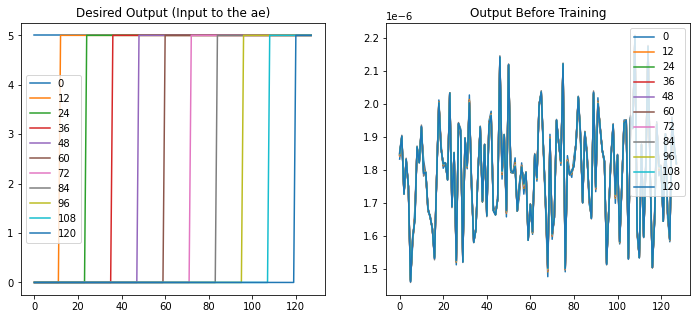

In [7]:
%matplotlib inline
fig = plt.figure(figsize = (12,5))

axes = fig.subplots(1,2)

for n in np.arange(0, 128, 12):
  axes[0].plot(X[:,r[n]], label = n)
  axes[1].plot(ae.forward(X[:,r[n]]).detach().numpy(), label = n)

axes[0].set_title("Desired Output (Input to the ae)")
axes[0].legend()
axes[1].set_title("Output Before Training")
axes[1].legend()

Text(0.5, 1.0, 'Initial values of W3')

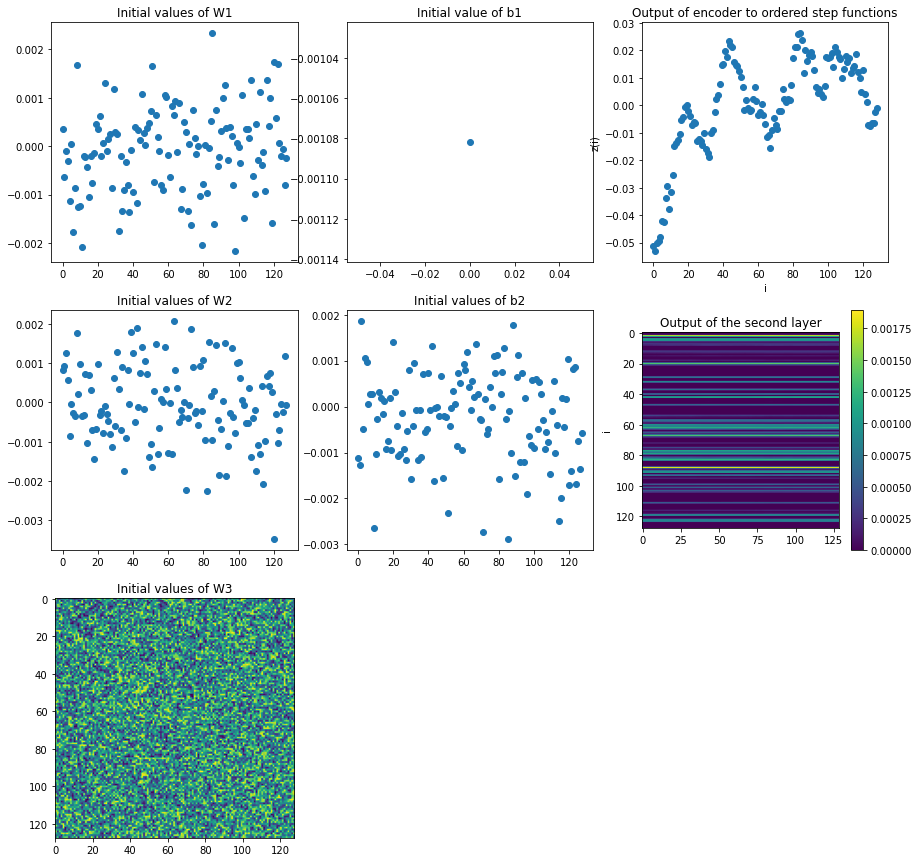

In [8]:
%matplotlib inline
# Analysing the weights

plt.figure(figsize= (15,15))

plt.subplot(331)
plt.scatter(np.arange(128), ae.W1.detach().numpy()[0])
plt.title("Initial values of W1")

plt.subplot(332)
plt.scatter(np.arange(1), ae.b1.detach().numpy()[0])
plt.title("Initial value of b1")

plt.subplot(333)
z_test = ae.W1 @ X_test + ae.b1
plt.scatter(np.arange(129), z_test.detach().numpy()[0])
plt.title("Output of encoder to ordered step functions")
plt.xlabel("i")
plt.ylabel("z(i)")

plt.subplot(334)
plt.scatter(np.arange(128), ae.W2.detach().numpy())
plt.title("Initial values of W2")

plt.subplot(335)
plt.scatter(np.arange(128), ae.b2.detach().numpy())
plt.title("Initial values of b2")

plt.subplot(336)
u2 = (ae.W2 @ z_test + ae.b2).detach().numpy()
plt.imshow((u2>0)*u2)
plt.title("Output of the second layer")
plt.ylabel("u2(i)")
plt.ylabel("i")
plt.colorbar()

plt.subplot(337)
plt.imshow(ae.W3.detach().numpy())
plt.title("Initial values of W3")

In [9]:
ae = AutoEncoder(n_in, n_h1, n_h2, n_out)

In [10]:
# Learning Rate 
alpha =0.5e-4
# Number of epochs
nb_epochs = 500000

In [11]:
t=100

losses = []
avg_loss = np.zeros(t)

In [12]:
ae.rest_S()

In [13]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [14]:
fig = plt.figure()
weights = torch.outer(torch.arange(128,0,-1,dtype=torch.float),torch.ones(129,dtype=torch.float))

<Figure size 432x288 with 0 Axes>

<IPython.core.display.Javascript object>


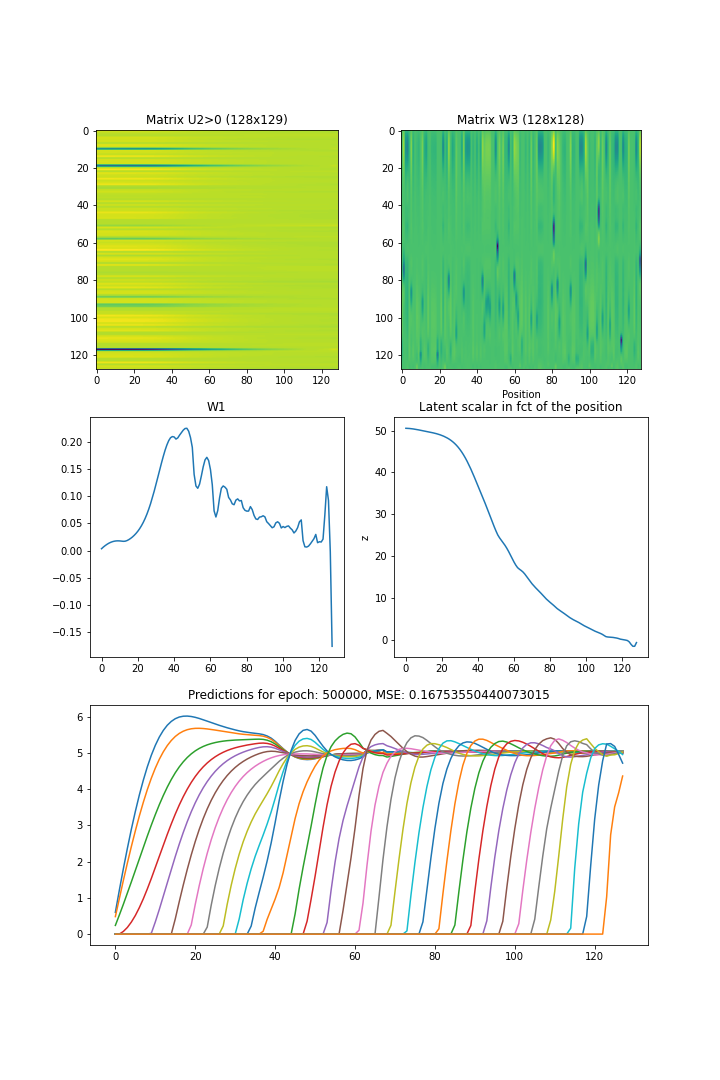

epoch 100 - loss: 12.499728212356567
epoch 200 - loss: 12.496513147354126
epoch 300 - loss: 12.481714363098144
epoch 400 - loss: 12.43804871559143
epoch 500 - loss: 12.345010223388671
epoch 600 - loss: 12.183034210205077
epoch 700 - loss: 11.935831489562988
epoch 800 - loss: 11.590981349945068
epoch 900 - loss: 11.139550371170044
epoch 1000 - loss: 10.57784321784973
epoch 1100 - loss: 9.90810881614685
epoch 1200 - loss: 9.138977689743042
epoch 1300 - loss: 8.286900897026062
epoch 1400 - loss: 7.375929012298584
epoch 1500 - loss: 6.438596963882446
epoch 1600 - loss: 5.514580807685852
epoch 1700 - loss: 4.64862425327301
epoch 1800 - loss: 3.88683895111084
epoch 1900 - loss: 3.2714637899398804
epoch 2000 - loss: 2.8328557658195495
epoch 2100 - loss: 2.577303795814514
epoch 2200 - loss: 2.470333833694458
epoch 2300 - loss: 2.4382083582878114
epoch 2400 - loss: 2.4274544763565062
epoch 2500 - loss: 2.4190068197250367
epoch 2600 - loss: 2.4104969000816343
epoch 2700 - loss: 2.402144811153412

epoch 21600 - loss: 0.6901794350147248
epoch 21700 - loss: 0.6879288589954377
epoch 21800 - loss: 0.6856939160823822
epoch 21900 - loss: 0.6834698277711868
epoch 22000 - loss: 0.6812573039531707
epoch 22100 - loss: 0.6790669226646423
epoch 22200 - loss: 0.6768891566991806
epoch 22300 - loss: 0.6747275871038437
epoch 22400 - loss: 0.6725768226385117
epoch 22500 - loss: 0.670439350605011
epoch 22600 - loss: 0.6683124732971192
epoch 22700 - loss: 0.6661987912654876
epoch 22800 - loss: 0.6641070300340652
epoch 22900 - loss: 0.6620346182584762
epoch 23000 - loss: 0.6599789500236511
epoch 23100 - loss: 0.657943207025528
epoch 23200 - loss: 0.6559273034334183
epoch 23300 - loss: 0.653923162817955
epoch 23400 - loss: 0.6519398784637451
epoch 23500 - loss: 0.6499695205688476
epoch 23600 - loss: 0.6480081361532212
epoch 23700 - loss: 0.6460601645708084
epoch 23800 - loss: 0.6441249448060989
epoch 23900 - loss: 0.6421992635726929
epoch 24000 - loss: 0.6402909690141678
epoch 24100 - loss: 0.638399

epoch 42600 - loss: 0.45279658526182176
epoch 42700 - loss: 0.45228518545627594
epoch 42800 - loss: 0.4517748886346817
epoch 42900 - loss: 0.4512664034962654
epoch 43000 - loss: 0.4507651177048683
epoch 43100 - loss: 0.4502555537223816
epoch 43200 - loss: 0.4497563162446022
epoch 43300 - loss: 0.4492515289783478
epoch 43400 - loss: 0.448757089972496
epoch 43500 - loss: 0.4482594361901283
epoch 43600 - loss: 0.44776854664087296
epoch 43700 - loss: 0.44727671027183535
epoch 43800 - loss: 0.44678915172815326
epoch 43900 - loss: 0.446302707195282
epoch 44000 - loss: 0.4458187559247017
epoch 44100 - loss: 0.4453425428271294
epoch 44200 - loss: 0.44485808730125426
epoch 44300 - loss: 0.4443835762143135
epoch 44400 - loss: 0.44390300691127776
epoch 44500 - loss: 0.4434316742420197
epoch 44600 - loss: 0.4429563757777214
epoch 44700 - loss: 0.4424873724579811
epoch 44800 - loss: 0.44201758682727815
epoch 44900 - loss: 0.4415516322851181
epoch 45000 - loss: 0.4410866338014603
epoch 45100 - loss:

epoch 63500 - loss: 0.3772094389796257
epoch 63600 - loss: 0.3769435873627663
epoch 63700 - loss: 0.3766785550117493
epoch 63800 - loss: 0.376412952542305
epoch 63900 - loss: 0.37615508407354353
epoch 64000 - loss: 0.37588718682527544
epoch 64100 - loss: 0.37562559723854066
epoch 64200 - loss: 0.3753589794039726
epoch 64300 - loss: 0.3750983375310898
epoch 64400 - loss: 0.37483430564403536
epoch 64500 - loss: 0.3745743152499199
epoch 64600 - loss: 0.3743129137158394
epoch 64700 - loss: 0.3740531086921692
epoch 64800 - loss: 0.37379408538341524
epoch 64900 - loss: 0.3735350024700165
epoch 65000 - loss: 0.3732838597893715
epoch 65100 - loss: 0.37302239805459975
epoch 65200 - loss: 0.3727673363685608
epoch 65300 - loss: 0.3725069412589073
epoch 65400 - loss: 0.37225261390209197
epoch 65500 - loss: 0.3719950744509697
epoch 65600 - loss: 0.37174089312553404
epoch 65700 - loss: 0.37148579955101013
epoch 65800 - loss: 0.37123179525136946
epoch 65900 - loss: 0.3709787178039551
epoch 66000 - lo

epoch 84400 - loss: 0.33185549020767213
epoch 84500 - loss: 0.33168243676424025
epoch 84600 - loss: 0.3315101394057274
epoch 84700 - loss: 0.33133735865354536
epoch 84800 - loss: 0.33117219477891924
epoch 84900 - loss: 0.330997057557106
epoch 85000 - loss: 0.3308269998431206
epoch 85100 - loss: 0.3306522971391678
epoch 85200 - loss: 0.33048294484615326
epoch 85300 - loss: 0.3303110691905022
epoch 85400 - loss: 0.330141978263855
epoch 85500 - loss: 0.32997234523296354
epoch 85600 - loss: 0.3298033770918846
epoch 85700 - loss: 0.3296356624364853
epoch 85800 - loss: 0.3294670236110687
epoch 85900 - loss: 0.329306578040123
epoch 86000 - loss: 0.3291355511546135
epoch 86100 - loss: 0.3289699110388756
epoch 86200 - loss: 0.3287996816635132
epoch 86300 - loss: 0.3286346027255058
epoch 86400 - loss: 0.32846702754497525
epoch 86500 - loss: 0.32830219238996505
epoch 86600 - loss: 0.3281367164850235
epoch 86700 - loss: 0.3279721316695213
epoch 86800 - loss: 0.3278086119890213
epoch 86900 - loss: 

epoch 105100 - loss: 0.30267348408699035
epoch 105200 - loss: 0.30255655616521837
epoch 105300 - loss: 0.30243929117918017
epoch 105400 - loss: 0.30232239842414854
epoch 105500 - loss: 0.3022043225169182
epoch 105600 - loss: 0.3020856776833534
epoch 105700 - loss: 0.3019808307290077
epoch 105800 - loss: 0.30185182094573976
epoch 105900 - loss: 0.3017460584640503
epoch 106000 - loss: 0.3016290307044983
epoch 106100 - loss: 0.3015111324191093
epoch 106200 - loss: 0.30139169961214063
epoch 106300 - loss: 0.30127608239650727
epoch 106400 - loss: 0.30116106897592543
epoch 106500 - loss: 0.301045156121254
epoch 106600 - loss: 0.3009306514263153
epoch 106700 - loss: 0.3008152738213539
epoch 106800 - loss: 0.3007064667344093
epoch 106900 - loss: 0.3005918848514557
epoch 107000 - loss: 0.3004764956235886
epoch 107100 - loss: 0.3003585287928581
epoch 107200 - loss: 0.30024479895830153
epoch 107300 - loss: 0.300128843486309
epoch 107400 - loss: 0.3000151526927948
epoch 107500 - loss: 0.2999011847

epoch 125400 - loss: 0.28176222324371336
epoch 125500 - loss: 0.28167805314064026
epoch 125600 - loss: 0.2815860730409622
epoch 125700 - loss: 0.2814956894516945
epoch 125800 - loss: 0.28140243589878083
epoch 125900 - loss: 0.2813097995519638
epoch 126000 - loss: 0.28121777474880216
epoch 126100 - loss: 0.28112957715988157
epoch 126200 - loss: 0.2810387101769447
epoch 126300 - loss: 0.28094774186611177
epoch 126400 - loss: 0.28085968911647796
epoch 126500 - loss: 0.2807693412899971
epoch 126600 - loss: 0.28068586468696594
epoch 126700 - loss: 0.2805940401554108
epoch 126800 - loss: 0.28050667643547056
epoch 126900 - loss: 0.28041144609451296
epoch 127000 - loss: 0.28032433331012724
epoch 127100 - loss: 0.28023215115070343
epoch 127200 - loss: 0.2801431715488434
epoch 127300 - loss: 0.28005345731973647
epoch 127400 - loss: 0.27996468663215635
epoch 127500 - loss: 0.27987618029117584
epoch 127600 - loss: 0.2797865033149719
epoch 127700 - loss: 0.27971053153276443
epoch 127800 - loss: 0.2

epoch 145700 - loss: 0.265308997631073
epoch 145800 - loss: 0.26523125886917115
epoch 145900 - loss: 0.2651618319749832
epoch 146000 - loss: 0.26508980691432954
epoch 146100 - loss: 0.265018158853054
epoch 146200 - loss: 0.2649482634663582
epoch 146300 - loss: 0.2648764485120773
epoch 146400 - loss: 0.2648094841837883
epoch 146500 - loss: 0.2647422608733177
epoch 146600 - loss: 0.26467014104127884
epoch 146700 - loss: 0.264595989882946
epoch 146800 - loss: 0.26452527701854706
epoch 146900 - loss: 0.2644485005736351
epoch 147000 - loss: 0.26438117802143096
epoch 147100 - loss: 0.2643101972341537
epoch 147200 - loss: 0.26424072474241256
epoch 147300 - loss: 0.26417171984910964
epoch 147400 - loss: 0.26409990191459654
epoch 147500 - loss: 0.26403700798749924
epoch 147600 - loss: 0.26396586656570437
epoch 147700 - loss: 0.26389732271432875
epoch 147800 - loss: 0.2638133546710014
epoch 147900 - loss: 0.2637534201145172
epoch 148000 - loss: 0.2636833345890045
epoch 148100 - loss: 0.263607432

epoch 166000 - loss: 0.2524355575442314
epoch 166100 - loss: 0.2523820152878761
epoch 166200 - loss: 0.2523278373479843
epoch 166300 - loss: 0.2522718831896782
epoch 166400 - loss: 0.252220958173275
epoch 166500 - loss: 0.25214947402477267
epoch 166600 - loss: 0.25210518687963485
epoch 166700 - loss: 0.2520433050394058
epoch 166800 - loss: 0.25199145525693895
epoch 166900 - loss: 0.251933870613575
epoch 167000 - loss: 0.2518772977590561
epoch 167100 - loss: 0.251822352707386
epoch 167200 - loss: 0.2517693698406219
epoch 167300 - loss: 0.25171940922737124
epoch 167400 - loss: 0.25166272819042207
epoch 167500 - loss: 0.2516091313958168
epoch 167600 - loss: 0.2515439873933792
epoch 167700 - loss: 0.2514992934465408
epoch 167800 - loss: 0.25143854826688766
epoch 167900 - loss: 0.251380078792572
epoch 168000 - loss: 0.25132802307605745
epoch 168100 - loss: 0.25127408862113954
epoch 168200 - loss: 0.25121853440999986
epoch 168300 - loss: 0.25116105943918227
epoch 168400 - loss: 0.25111619919

epoch 186200 - loss: 0.24214111968874932
epoch 186300 - loss: 0.24208746805787087
epoch 186400 - loss: 0.24203698784112931
epoch 186500 - loss: 0.24199287906289102
epoch 186600 - loss: 0.24194357857108117
epoch 186700 - loss: 0.24189854755997658
epoch 186800 - loss: 0.24184955507516862
epoch 186900 - loss: 0.24180480420589448
epoch 187000 - loss: 0.2417602175474167
epoch 187100 - loss: 0.24172518029808998
epoch 187200 - loss: 0.2416652625799179
epoch 187300 - loss: 0.24163349598646164
epoch 187400 - loss: 0.241580248773098
epoch 187500 - loss: 0.24152966931462289
epoch 187600 - loss: 0.2414831192791462
epoch 187700 - loss: 0.24144089445471764
epoch 187800 - loss: 0.24139162227511407
epoch 187900 - loss: 0.24134597763419152
epoch 188000 - loss: 0.2413022607564926
epoch 188100 - loss: 0.2412583400309086
epoch 188200 - loss: 0.24121444821357726
epoch 188300 - loss: 0.2411716513335705
epoch 188400 - loss: 0.24112839221954346
epoch 188500 - loss: 0.24107752308249475
epoch 188600 - loss: 0.2

epoch 206400 - loss: 0.23356275603175164
epoch 206500 - loss: 0.2335227257013321
epoch 206600 - loss: 0.2334897018969059
epoch 206700 - loss: 0.23343977376818656
epoch 206800 - loss: 0.23340166389942169
epoch 206900 - loss: 0.23337152242660522
epoch 207000 - loss: 0.23333268761634826
epoch 207100 - loss: 0.23328593075275422
epoch 207200 - loss: 0.23325314238667488
epoch 207300 - loss: 0.23321153238415718
epoch 207400 - loss: 0.2331667213141918
epoch 207500 - loss: 0.23313091695308685
epoch 207600 - loss: 0.23309482559561728
epoch 207700 - loss: 0.23305367797613144
epoch 207800 - loss: 0.23301536858081817
epoch 207900 - loss: 0.23297362700104712
epoch 208000 - loss: 0.23294546693563462
epoch 208100 - loss: 0.23290653824806212
epoch 208200 - loss: 0.2328665053844452
epoch 208300 - loss: 0.23282431021332742
epoch 208400 - loss: 0.23278114601969718
epoch 208500 - loss: 0.2327496027946472
epoch 208600 - loss: 0.23271117299795152
epoch 208700 - loss: 0.23266338288784028
epoch 208800 - loss: 

epoch 226600 - loss: 0.22608826458454132
epoch 226700 - loss: 0.226067645996809
epoch 226800 - loss: 0.22603057831525802
epoch 226900 - loss: 0.22598709613084794
epoch 227000 - loss: 0.22595071762800217
epoch 227100 - loss: 0.22591748535633088
epoch 227200 - loss: 0.22588077649474145
epoch 227300 - loss: 0.22584447696805
epoch 227400 - loss: 0.22581347063183785
epoch 227500 - loss: 0.2257699438929558
epoch 227600 - loss: 0.22573793798685074
epoch 227700 - loss: 0.22570299237966537
epoch 227800 - loss: 0.225675880163908
epoch 227900 - loss: 0.2256396643817425
epoch 228000 - loss: 0.22560283303260803
epoch 228100 - loss: 0.2255472359061241
epoch 228200 - loss: 0.2255315999686718
epoch 228300 - loss: 0.22548889487981796
epoch 228400 - loss: 0.22545250937342642
epoch 228500 - loss: 0.22541878625750542
epoch 228600 - loss: 0.22537809744477272
epoch 228700 - loss: 0.22534665048122407
epoch 228800 - loss: 0.22530705660581588
epoch 228900 - loss: 0.22527720510959626
epoch 229000 - loss: 0.2252

epoch 246800 - loss: 0.21917876943945885
epoch 246900 - loss: 0.21915419921278953
epoch 247000 - loss: 0.21911709040403365
epoch 247100 - loss: 0.21908237636089326
epoch 247200 - loss: 0.2190488576889038
epoch 247300 - loss: 0.2190100745856762
epoch 247400 - loss: 0.21897790640592574
epoch 247500 - loss: 0.21895055934786797
epoch 247600 - loss: 0.2189178214967251
epoch 247700 - loss: 0.2188834208250046
epoch 247800 - loss: 0.21885294049978257
epoch 247900 - loss: 0.21881476566195487
epoch 248000 - loss: 0.21878081813454628
epoch 248100 - loss: 0.21875041276216506
epoch 248200 - loss: 0.21871745511889457
epoch 248300 - loss: 0.21868158623576164
epoch 248400 - loss: 0.21865700230002402
epoch 248500 - loss: 0.2186128206551075
epoch 248600 - loss: 0.21858557671308518
epoch 248700 - loss: 0.21856020659208297
epoch 248800 - loss: 0.21852563202381134
epoch 248900 - loss: 0.21849784046411513
epoch 249000 - loss: 0.21845510929822923
epoch 249100 - loss: 0.21842602357268334
epoch 249200 - loss: 

epoch 267000 - loss: 0.2126305802166462
epoch 267100 - loss: 0.2125973469018936
epoch 267200 - loss: 0.21256662994623185
epoch 267300 - loss: 0.21253114998340605
epoch 267400 - loss: 0.2125059248507023
epoch 267500 - loss: 0.21248111695051194
epoch 267600 - loss: 0.2124321810901165
epoch 267700 - loss: 0.21240735933184623
epoch 267800 - loss: 0.21237210884690286
epoch 267900 - loss: 0.21233442336320876
epoch 268000 - loss: 0.21230507239699364
epoch 268100 - loss: 0.21226929605007172
epoch 268200 - loss: 0.21223812460899352
epoch 268300 - loss: 0.21220675855875015
epoch 268400 - loss: 0.21217399954795838
epoch 268500 - loss: 0.21215293154120446
epoch 268600 - loss: 0.21211546897888184
epoch 268700 - loss: 0.2120842519402504
epoch 268800 - loss: 0.21204532265663148
epoch 268900 - loss: 0.21202345967292785
epoch 269000 - loss: 0.21198241174221039
epoch 269100 - loss: 0.2119535420835018
epoch 269200 - loss: 0.21191815599799158
epoch 269300 - loss: 0.2118843226134777
epoch 269400 - loss: 0.

epoch 287200 - loss: 0.20622954726219178
epoch 287300 - loss: 0.2061898699402809
epoch 287400 - loss: 0.20615845650434494
epoch 287500 - loss: 0.20614216297864915
epoch 287600 - loss: 0.20610037535429002
epoch 287700 - loss: 0.20606832891702653
epoch 287800 - loss: 0.2060330668091774
epoch 287900 - loss: 0.20600268766283988
epoch 288000 - loss: 0.2059783999621868
epoch 288100 - loss: 0.20594401210546492
epoch 288200 - loss: 0.20590975433588027
epoch 288300 - loss: 0.20588796496391296
epoch 288400 - loss: 0.2058580869436264
epoch 288500 - loss: 0.20581937417387963
epoch 288600 - loss: 0.20579708009958267
epoch 288700 - loss: 0.20575660541653634
epoch 288800 - loss: 0.20573024332523346
epoch 288900 - loss: 0.20569812700152398
epoch 289000 - loss: 0.2056708078086376
epoch 289100 - loss: 0.2056318324804306
epoch 289200 - loss: 0.20560785338282586
epoch 289300 - loss: 0.2055779577791691
epoch 289400 - loss: 0.2055418846011162
epoch 289500 - loss: 0.20552705705165863
epoch 289600 - loss: 0.2

epoch 307400 - loss: 0.20009525418281554
epoch 307500 - loss: 0.20006492987275123
epoch 307600 - loss: 0.2000300370156765
epoch 307700 - loss: 0.2000051400065422
epoch 307800 - loss: 0.19997362315654754
epoch 307900 - loss: 0.19994563564658166
epoch 308000 - loss: 0.19991774082183839
epoch 308100 - loss: 0.19989893317222596
epoch 308200 - loss: 0.19986853301525115
epoch 308300 - loss: 0.1998298582434654
epoch 308400 - loss: 0.19979350730776788
epoch 308500 - loss: 0.19978004738688468
epoch 308600 - loss: 0.1997380794584751
epoch 308700 - loss: 0.19971227258443833
epoch 308800 - loss: 0.19968196958303452
epoch 308900 - loss: 0.1996519808471203
epoch 309000 - loss: 0.1996178586781025
epoch 309100 - loss: 0.1995914101600647
epoch 309200 - loss: 0.1995695051550865
epoch 309300 - loss: 0.1995491451025009
epoch 309400 - loss: 0.19952405333518983
epoch 309500 - loss: 0.19948874294757843
epoch 309600 - loss: 0.1994544583559036
epoch 309700 - loss: 0.19942980274558067
epoch 309800 - loss: 0.199

epoch 327600 - loss: 0.1944864046573639
epoch 327700 - loss: 0.19445185169577597
epoch 327800 - loss: 0.19442678228020668
epoch 327900 - loss: 0.19441237911581993
epoch 328000 - loss: 0.19438587829470635
epoch 328100 - loss: 0.19435556292533873
epoch 328200 - loss: 0.19432767018675803
epoch 328300 - loss: 0.19430391758680343
epoch 328400 - loss: 0.19427476048469544
epoch 328500 - loss: 0.19424591988325118
epoch 328600 - loss: 0.1942211264371872
epoch 328700 - loss: 0.19419638842344283
epoch 328800 - loss: 0.19416946217417716
epoch 328900 - loss: 0.19414106249809265
epoch 329000 - loss: 0.1941293843090534
epoch 329100 - loss: 0.19409594908356667
epoch 329200 - loss: 0.19406788423657417
epoch 329300 - loss: 0.19403845623135565
epoch 329400 - loss: 0.1940085308253765
epoch 329500 - loss: 0.19397977948188783
epoch 329600 - loss: 0.19395433381199836
epoch 329700 - loss: 0.19392901182174682
epoch 329800 - loss: 0.1939011472463608
epoch 329900 - loss: 0.1938784474134445
epoch 330000 - loss: 0

epoch 347800 - loss: 0.18951535299420358
epoch 347900 - loss: 0.18951044082641602
epoch 348000 - loss: 0.1894684301316738
epoch 348100 - loss: 0.1894536243379116
epoch 348200 - loss: 0.1894245508313179
epoch 348300 - loss: 0.18939974948763846
epoch 348400 - loss: 0.18938048347830772
epoch 348500 - loss: 0.18935116559267043
epoch 348600 - loss: 0.1893343833088875
epoch 348700 - loss: 0.18930935725569725
epoch 348800 - loss: 0.18929648756980896
epoch 348900 - loss: 0.18927322700619698
epoch 349000 - loss: 0.18924702540040017
epoch 349100 - loss: 0.18922102943062782
epoch 349200 - loss: 0.18919407069683075
epoch 349300 - loss: 0.1891694897413254
epoch 349400 - loss: 0.1891442756354809
epoch 349500 - loss: 0.18912335932254792
epoch 349600 - loss: 0.18909775853157043
epoch 349700 - loss: 0.18907653272151947
epoch 349800 - loss: 0.1890524473786354
epoch 349900 - loss: 0.18904095768928528
epoch 350000 - loss: 0.18901167050004006
epoch 350100 - loss: 0.18899313911795615
epoch 350200 - loss: 0.

epoch 368000 - loss: 0.18527054622769357
epoch 368100 - loss: 0.1852530825138092
epoch 368200 - loss: 0.18523520603775978
epoch 368300 - loss: 0.18521039739251136
epoch 368400 - loss: 0.18519058495759963
epoch 368500 - loss: 0.1851755703985691
epoch 368600 - loss: 0.1851517915725708
epoch 368700 - loss: 0.18514461517333985
epoch 368800 - loss: 0.18510988652706145
epoch 368900 - loss: 0.18508875399827956
epoch 369000 - loss: 0.18507082343101502
epoch 369100 - loss: 0.18505200907588004
epoch 369200 - loss: 0.18502954185009002
epoch 369300 - loss: 0.18501023441553116
epoch 369400 - loss: 0.1849853953719139
epoch 369500 - loss: 0.18497319489717484
epoch 369600 - loss: 0.1849493408203125
epoch 369700 - loss: 0.18493199586868286
epoch 369800 - loss: 0.18491588443517684
epoch 369900 - loss: 0.18489209160208703
epoch 370000 - loss: 0.1848699016869068
epoch 370100 - loss: 0.18484985634684561
epoch 370200 - loss: 0.18482988566160202
epoch 370300 - loss: 0.18480880454182624
epoch 370400 - loss: 0

epoch 388200 - loss: 0.18152595281600953
epoch 388300 - loss: 0.18150943472981454
epoch 388400 - loss: 0.1815039974451065
epoch 388500 - loss: 0.18148059636354447
epoch 388600 - loss: 0.18146308064460753
epoch 388700 - loss: 0.18143630027770996
epoch 388800 - loss: 0.18142529368400573
epoch 388900 - loss: 0.1814070338010788
epoch 389000 - loss: 0.18138485431671142
epoch 389100 - loss: 0.18136708199977875
epoch 389200 - loss: 0.18135397747159004
epoch 389300 - loss: 0.18133209452033042
epoch 389400 - loss: 0.18132131665945053
epoch 389500 - loss: 0.18130838066339494
epoch 389600 - loss: 0.18128719359636306
epoch 389700 - loss: 0.18126820355653764
epoch 389800 - loss: 0.18124583899974822
epoch 389900 - loss: 0.18123035833239556
epoch 390000 - loss: 0.18122171401977538
epoch 390100 - loss: 0.1811976619064808
epoch 390200 - loss: 0.181184733659029
epoch 390300 - loss: 0.18116102740168571
epoch 390400 - loss: 0.1811496791243553
epoch 390500 - loss: 0.1811327561736107
epoch 390600 - loss: 0.

epoch 408400 - loss: 0.17833080649375915
epoch 408500 - loss: 0.1783183531463146
epoch 408600 - loss: 0.17829262793064118
epoch 408700 - loss: 0.1782895040512085
epoch 408800 - loss: 0.17826730027794838
epoch 408900 - loss: 0.1782467058300972
epoch 409000 - loss: 0.1782447662949562
epoch 409100 - loss: 0.1782200288772583
epoch 409200 - loss: 0.1782170730829239
epoch 409300 - loss: 0.17820043802261354
epoch 409400 - loss: 0.17819955661892892
epoch 409500 - loss: 0.17817221224308014
epoch 409600 - loss: 0.178160420358181
epoch 409700 - loss: 0.1781393377482891
epoch 409800 - loss: 0.17812591269612313
epoch 409900 - loss: 0.17811303958296776
epoch 410000 - loss: 0.17809172257781028
epoch 410100 - loss: 0.17807672947645187
epoch 410200 - loss: 0.178066136687994
epoch 410300 - loss: 0.17804763570427895
epoch 410400 - loss: 0.1780453382432461
epoch 410500 - loss: 0.17803138136863708
epoch 410600 - loss: 0.17801806971430778
epoch 410700 - loss: 0.17799850478768348
epoch 410800 - loss: 0.17797

epoch 428600 - loss: 0.1755383238196373
epoch 428700 - loss: 0.17551777854561806
epoch 428800 - loss: 0.17550524264574052
epoch 428900 - loss: 0.1754939767718315
epoch 429000 - loss: 0.17547986209392546
epoch 429100 - loss: 0.17547151327133179
epoch 429200 - loss: 0.17546660408377648
epoch 429300 - loss: 0.17545017525553702
epoch 429400 - loss: 0.17542897447943687
epoch 429500 - loss: 0.17541323572397233
epoch 429600 - loss: 0.1753941957652569
epoch 429700 - loss: 0.17538857087492943
epoch 429800 - loss: 0.17537132248282433
epoch 429900 - loss: 0.17536247476935388
epoch 430000 - loss: 0.17534699246287347
epoch 430100 - loss: 0.17533559426665307
epoch 430200 - loss: 0.17534049451351166
epoch 430300 - loss: 0.17532050773501395
epoch 430400 - loss: 0.17529401496052743
epoch 430500 - loss: 0.17529132798314095
epoch 430600 - loss: 0.1752622027695179
epoch 430700 - loss: 0.17526163026690483
epoch 430800 - loss: 0.17523761540651323
epoch 430900 - loss: 0.1752282689511776
epoch 431000 - loss: 

epoch 448800 - loss: 0.17295618176460267
epoch 448900 - loss: 0.17295555412769317
epoch 449000 - loss: 0.17293603241443634
epoch 449100 - loss: 0.17292529910802842
epoch 449200 - loss: 0.17290861010551453
epoch 449300 - loss: 0.1728983260691166
epoch 449400 - loss: 0.17288594886660577
epoch 449500 - loss: 0.17287948071956635
epoch 449600 - loss: 0.17287009760737418
epoch 449700 - loss: 0.17284480452537537
epoch 449800 - loss: 0.17283657550811768
epoch 449900 - loss: 0.17282631903886794
epoch 450000 - loss: 0.1728273394703865
epoch 450100 - loss: 0.1728042781352997
epoch 450200 - loss: 0.17279786616563797
epoch 450300 - loss: 0.1727776473760605
epoch 450400 - loss: 0.17276842296123504
epoch 450500 - loss: 0.17275117814540863
epoch 450600 - loss: 0.17273900866508485
epoch 450700 - loss: 0.1727365192770958
epoch 450800 - loss: 0.17271321654319763
epoch 450900 - loss: 0.1727053126692772
epoch 451000 - loss: 0.17269851312041282
epoch 451100 - loss: 0.17268755808472633
epoch 451200 - loss: 0

epoch 469000 - loss: 0.1706452701985836
epoch 469100 - loss: 0.17064232379198074
epoch 469200 - loss: 0.1706235407292843
epoch 469300 - loss: 0.17061236798763274
epoch 469400 - loss: 0.17060447707772255
epoch 469500 - loss: 0.17059536889195442
epoch 469600 - loss: 0.1705823212862015
epoch 469700 - loss: 0.17057908639311792
epoch 469800 - loss: 0.17056777074933052
epoch 469900 - loss: 0.17055777922272683
epoch 470000 - loss: 0.17053903505206108
epoch 470100 - loss: 0.17052851408720016
epoch 470200 - loss: 0.17050991252064704
epoch 470300 - loss: 0.17050850242376328
epoch 470400 - loss: 0.17048876151442527
epoch 470500 - loss: 0.170484781563282
epoch 470600 - loss: 0.1704649505019188
epoch 470700 - loss: 0.17045675560832024
epoch 470800 - loss: 0.17044939681887628
epoch 470900 - loss: 0.17044658824801445
epoch 471000 - loss: 0.17042962908744813
epoch 471100 - loss: 0.17042239814996718
epoch 471200 - loss: 0.17039585441350938
epoch 471300 - loss: 0.1704082852602005
epoch 471400 - loss: 0.

epoch 489200 - loss: 0.16859142661094664
epoch 489300 - loss: 0.16858380705118178
epoch 489400 - loss: 0.1685676933825016
epoch 489500 - loss: 0.1685608907043934
epoch 489600 - loss: 0.16855975702404977
epoch 489700 - loss: 0.16853634014725685
epoch 489800 - loss: 0.16853592604398726
epoch 489900 - loss: 0.16852057456970215
epoch 490000 - loss: 0.16850417450070382
epoch 490100 - loss: 0.16849991232156752
epoch 490200 - loss: 0.16849181234836577
epoch 490300 - loss: 0.16848028019070627
epoch 490400 - loss: 0.1684625667333603
epoch 490500 - loss: 0.1684545874595642
epoch 490600 - loss: 0.1684447258710861
epoch 490700 - loss: 0.1684420508146286
epoch 490800 - loss: 0.16843392968177795
epoch 490900 - loss: 0.16841046899557113
epoch 491000 - loss: 0.1684081056714058
epoch 491100 - loss: 0.1683970147371292
epoch 491200 - loss: 0.16839083328843116
epoch 491300 - loss: 0.1683748246729374
epoch 491400 - loss: 0.16837298676371573
epoch 491500 - loss: 0.16835703074932098
epoch 491600 - loss: 0.16

<IPython.core.display.Javascript object>


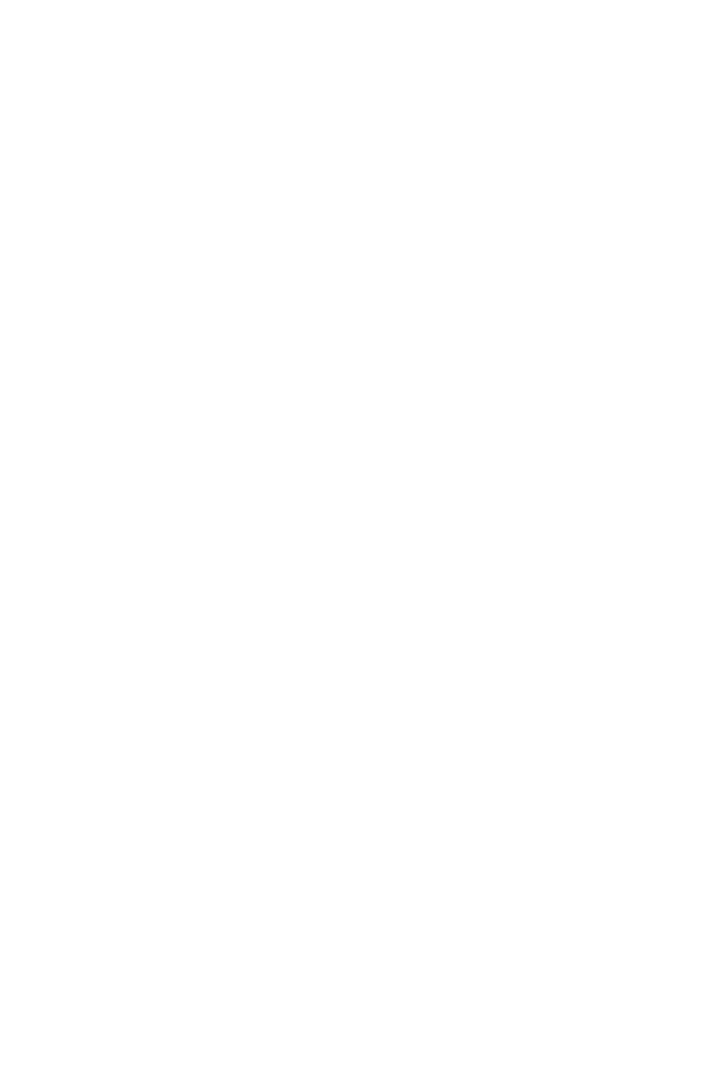

In [15]:
%matplotlib notebook

fig = plt.figure(figsize = (10,15))

ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(313)

fig.show()
fig.canvas.draw()

for epoch in range(nb_epochs):

  Y = ae.forward(X)

  #loss = nn.MSELoss()(Y, X) 
  loss = torch.mean(torch.mean((Y-X)**2,0))
  #loss = torch.mean(torch.mean((weights)*(Y-X)**2,0))
    
  avg_loss[epoch%t] = loss

  loss.backward()

  ae.optim_step(alpha,0.9)

  if (epoch + 1 )%t == 0:

    print(f"epoch {epoch + 1} - loss: {avg_loss.mean()}") 

    losses.append(avg_loss.mean())
    
    #Visualization
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax4.clear()
    ax5.clear()
    
    ax4.set_title("Latent scalar in fct of the position")
    ax4.set_ylabel("z")
    ax2.set_xlabel("Position")
    
    ax3.set_title(f"W1")

    ax1.set_title(f"Matrix U2>0 (128x129)")

    ax2.set_title(f"Matrix W3 (128x128)")
    
    ax5.set_title(f"Predictions for epoch: {epoch+1}, MSE: {avg_loss.mean()}")
    
    for n in np.arange(0, 128, 4):
        ax5.plot(ae.forward(X_test[:,n]).detach().numpy())
        
    
    ax3.plot(np.arange(128),ae.W1.detach().numpy()[0])
    
    z_test = (ae.W1 @ X_test + ae.b1)
    ax4.plot(np.arange(129),z_test.detach().numpy()[0])
    
    u2 = (ae.W2 @ z_test + ae.b2).detach().numpy()
    ax1.imshow((u2))
    
    ax2.imshow(ae.W3.detach().numpy())
    
    fig.canvas.draw()


Text(0.5, 0, 'epochs')

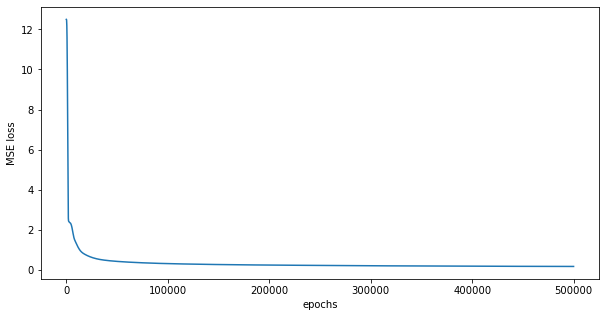

In [16]:
%matplotlib inline
plt.figure(figsize=(10,5))
plt.plot(t*np.arange(len(losses)),losses)
plt.ylabel("MSE loss")
plt.xlabel("epochs")

In [17]:
X_test[:,60]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5.])

In [18]:
(ae.W1 * X_test[:,60]).sum()

tensor(19.2748, grad_fn=<SumBackward0>)

Text(0.5, 1.0, 'Predicted')

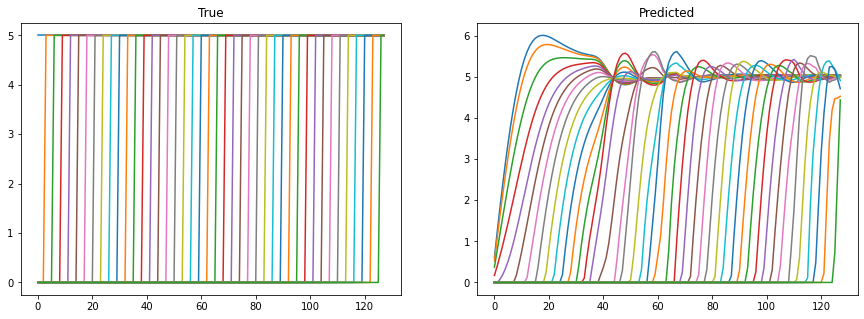

In [19]:
%matplotlib inline
fig = plt.figure(figsize = (15,5))

axes = fig.subplots(1,2)

for n in np.arange(0, 128, 3):
  axes[0].plot(X[:,r[n]], label = n)
  axes[1].plot(ae.forward(X[:,r[n]]).detach().numpy(), label = n)

axes[0].set_title("True")
#axes[0].legend()
axes[1].set_title("Predicted")
#axes[1].legend()

Text(0.5, 1.0, 'Initial values of W3')

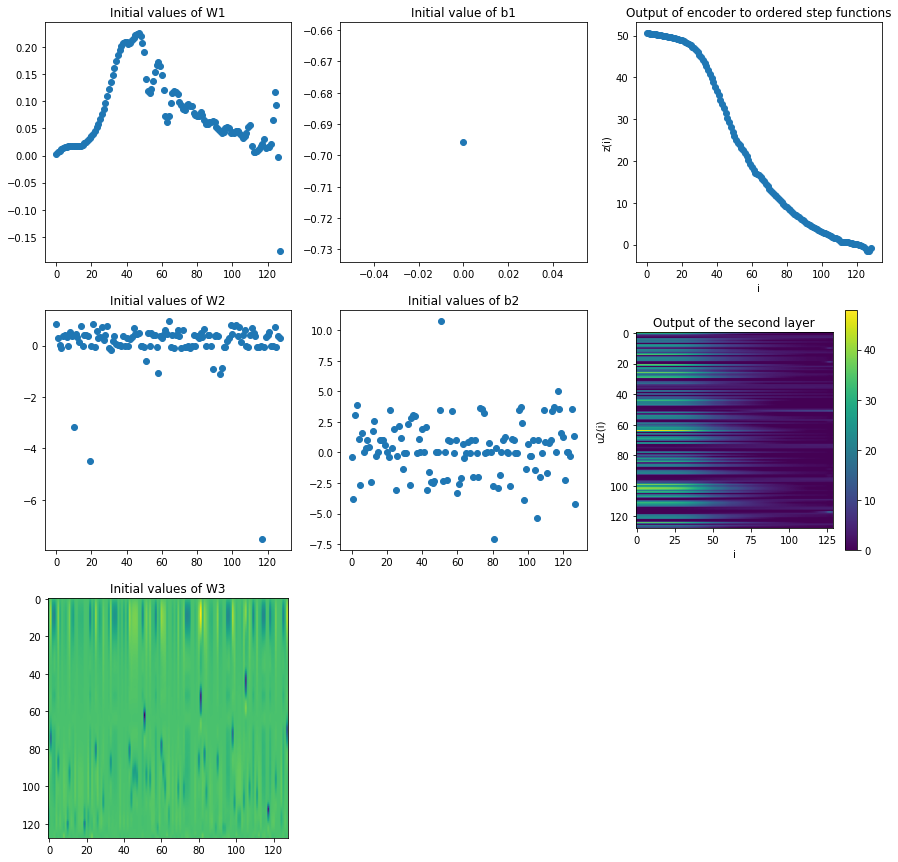

In [20]:
%matplotlib inline
# Analysing the weights

plt.figure(figsize= (15,15))

plt.subplot(331)
plt.scatter(np.arange(128), ae.W1.detach().numpy()[0])
plt.title("Initial values of W1")

plt.subplot(332)
plt.scatter(np.arange(1), ae.b1.detach().numpy()[0])
plt.title("Initial value of b1")

plt.subplot(333)
z_test = ae.W1 @ X_test + ae.b1
plt.scatter(np.arange(129), z_test.detach().numpy()[0])
plt.title("Output of encoder to ordered step functions")
plt.xlabel("i")
plt.ylabel("z(i)")

plt.subplot(334)
plt.scatter(np.arange(128), ae.W2.detach().numpy())
plt.title("Initial values of W2")

plt.subplot(335)
plt.scatter(np.arange(128), ae.b2.detach().numpy())
plt.title("Initial values of b2")

plt.subplot(336)
u2 = (ae.W2 @ z_test + ae.b2).detach().numpy()
plt.imshow((u2>0)*u2)
plt.title("Output of the second layer")
plt.ylabel("u2(i)")
plt.xlabel("i")
plt.colorbar()

plt.subplot(337)
plt.imshow(ae.W3.detach().numpy())
plt.title("Initial values of W3")